**MobileNetV2** (ImageNet transfer learning + fine-tuning). This is the best “mobile-friendly” baseline for your project (fast + decent accuracy)

In [1]:
# =========================================================
# CELL 0 — Check GPU + Imports
# =========================================================
import os, zipfile, shutil, pathlib, itertools, time
from collections import Counter


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

# Optional: allow GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Enabled memory growth")
    except Exception as e:
        print("⚠️ Could not set memory growth:", e)


TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Enabled memory growth


In [2]:
# =========================================================
# CELL 1 — Paths (EDIT THESE if needed)
# =========================================================
TRAIN_ZIP_PATH = "/content/Train.zip"     # <-- change if needed
VAL_ZIP_PATH   = "/content/Validation.zip"   # <-- change if needed

TRAIN_EXTRACT_DIR = "/content/gr_id_train"
VAL_EXTRACT_DIR   = "/content/gr_id_val"

print("TRAIN_ZIP_PATH:", TRAIN_ZIP_PATH)
print("VAL_ZIP_PATH:", VAL_ZIP_PATH)


TRAIN_ZIP_PATH: /content/Train.zip
VAL_ZIP_PATH: /content/Validation.zip


In [3]:
# =========================================================
# CELL 2 — Extract zips (cleanly)
# =========================================================
def extract_zip(zip_path, extract_dir):
    if os.path.exists(extract_dir):
        shutil.rmtree(extract_dir)
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
    return extract_dir

extract_zip(TRAIN_ZIP_PATH, TRAIN_EXTRACT_DIR)
extract_zip(VAL_ZIP_PATH, VAL_EXTRACT_DIR)

print("✅ Extracted:")
print(" - Train dir:", TRAIN_EXTRACT_DIR, "->", os.listdir(TRAIN_EXTRACT_DIR)[:10])
print(" - Val dir:", VAL_EXTRACT_DIR, "->", os.listdir(VAL_EXTRACT_DIR)[:10])


✅ Extracted:
 - Train dir: /content/gr_id_train -> ['train_real']
 - Val dir: /content/gr_id_val -> ['Validation']


In [4]:
# =========================================================
# CELL 3 — Find class-root folder (handles nesting)
# =========================================================
IMG_EXTS = (".jpg", ".jpeg", ".png")

def contains_images(folder):
    for r, _, fs in os.walk(folder):
        for f in fs:
            if f.lower().endswith(IMG_EXTS):
                return True
    return False

def find_class_root(root):
    dirs = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
    if len(dirs) >= 2 and any(contains_images(d) for d in dirs):
        return root
    if len(dirs) == 1:
        return find_class_root(dirs[0])
    return root

TRAIN_CLASS_ROOT = find_class_root(TRAIN_EXTRACT_DIR)
VAL_CLASS_ROOT   = find_class_root(VAL_EXTRACT_DIR)

print("TRAIN_CLASS_ROOT:", TRAIN_CLASS_ROOT)
print("VAL_CLASS_ROOT:", VAL_CLASS_ROOT)

print("Train folders:", sorted([d for d in os.listdir(TRAIN_CLASS_ROOT) if os.path.isdir(os.path.join(TRAIN_CLASS_ROOT,d))]))
print("Val folders:", sorted([d for d in os.listdir(VAL_CLASS_ROOT) if os.path.isdir(os.path.join(VAL_CLASS_ROOT,d))]))


TRAIN_CLASS_ROOT: /content/gr_id_train/train_real
VAL_CLASS_ROOT: /content/gr_id_val/Validation/val_real
Train folders: ['1508', 'Seela', 'Sufaid', 'ari', 'kachi', 'kachi_kainat', 'super']
Val folders: ['1508', 'Seela', 'Sufaid', 'ari', 'kachi', 'kachi_kainat', 'super']


In [5]:
# =========================================================
# CELL 4 — Dataset audit (counts, MBs, sizes)
# =========================================================
from PIL import Image

def dataset_audit(class_root):
    counts = Counter()
    total_imgs = 0
    total_bytes = 0
    sizes = Counter()
    exts = Counter()

    for cls in sorted(os.listdir(class_root)):
        cls_path = os.path.join(class_root, cls)
        if not os.path.isdir(cls_path):
            continue
        for r, _, fs in os.walk(cls_path):
            for f in fs:
                fl = f.lower()
                if not fl.endswith(IMG_EXTS):
                    continue
                fp = os.path.join(r, f)
                total_imgs += 1
                counts[cls] += 1
                total_bytes += os.path.getsize(fp)
                exts[pathlib.Path(f).suffix.lower()] += 1
                try:
                    with Image.open(fp) as im:
                        sizes[im.size] += 1
                except:
                    pass

    return counts, total_imgs, total_bytes, sizes, exts

train_counts, train_n, train_bytes, train_sizes, train_exts = dataset_audit(TRAIN_CLASS_ROOT)
val_counts,   val_n,   val_bytes,   val_sizes,   val_exts   = dataset_audit(VAL_CLASS_ROOT)

print("====== TRAIN SET ======")
print("Images:", train_n, "| Size (MB):", round(train_bytes/(1024*1024), 2), "| Classes:", len(train_counts))
for k,v in train_counts.most_common():
    print(f"  {k:15s} {v}")
print("Most common sizes (train):", train_sizes.most_common(3))

print("\n====== VALIDATION SET ======")
print("Images:", val_n, "| Size (MB):", round(val_bytes/(1024*1024), 2), "| Classes:", len(val_counts))
for k,v in val_counts.most_common():
    print(f"  {k:15s} {v}")
print("Most common sizes (val):", val_sizes.most_common(3))


====== TRAIN SET ======
Images: 7852 | Size (MB): 49.81 | Classes: 7
  Sufaid          1392
  super           1391
  kachi           1302
  Seela           1290
  ari             1119
  kachi_kainat    933
  1508            425
Most common sizes (train): [((224, 224), 7852)]

====== VALIDATION SET ======
Images: 3350 | Size (MB): 21.3 | Classes: 7
  super           600
  Sufaid          590
  Seela           550
  kachi           550
  ari             480
  kachi_kainat    400
  1508            180
Most common sizes (val): [((224, 224), 3350)]


In [36]:
# =========================================================
# CELL 5 — Hyperparams (GPU-specific for MobileNetV2)
# MobileNetV2 expects 224x224 canonically.
# =========================================================
SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 64     # MobileNet is light; 64 usually OK on GPU (drop to 32 if OOM)

EPOCHS_HEAD = 15
EPOCHS_FINE = 10

LR_HEAD = 1e-3
LR_FINE = 1e-5

print("IMG_SIZE:", IMG_SIZE, "BATCH_SIZE:", BATCH_SIZE)


IMG_SIZE: (224, 224) BATCH_SIZE: 64


In [7]:
# =========================================================
# CELL 6 — Build datasets (enforce same label mapping)
# =========================================================
class_names = sorted([d for d in os.listdir(TRAIN_CLASS_ROOT) if os.path.isdir(os.path.join(TRAIN_CLASS_ROOT, d))])
NUM_CLASSES = len(class_names)
class_to_id = {name: i for i, name in enumerate(class_names)}

print("Class names:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)

def list_files_and_labels(class_root, class_to_id):
    paths, labels = [], []
    for cls in class_to_id.keys():
        cls_dir = os.path.join(class_root, cls)
        if not os.path.exists(cls_dir):
            raise ValueError(f"Class '{cls}' missing in {class_root}. Found: {os.listdir(class_root)}")
        for r, _, fs in os.walk(cls_dir):
            for f in fs:
                if f.lower().endswith(IMG_EXTS):
                    paths.append(os.path.join(r, f))
                    labels.append(class_to_id[cls])
    return np.array(paths), np.array(labels, dtype=np.int32)

train_paths, train_labels = list_files_and_labels(TRAIN_CLASS_ROOT, class_to_id)
val_paths,   val_labels   = list_files_and_labels(VAL_CLASS_ROOT, class_to_id)

# Shuffle train
rng = np.random.default_rng(SEED)
idx = rng.permutation(len(train_paths))
train_paths, train_labels = train_paths[idx], train_labels[idx]

AUTOTUNE = tf.data.AUTOTUNE

def decode_any(path, label):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
train_ds = train_ds.map(decode_any, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(decode_any, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Train:", len(train_paths), "Val:", len(val_paths))


Class names: ['1508', 'Seela', 'Sufaid', 'ari', 'kachi', 'kachi_kainat', 'super']
NUM_CLASSES: 7
Train: 7852 Val: 3350


In [8]:
# =========================================================
# CELL 7 — Class weights (imbalance handling)
# =========================================================
class_count_arr = np.array([train_counts[name] for name in class_names], dtype=np.float32)
total = class_count_arr.sum()
class_weight = {i: float(total / (NUM_CLASSES * class_count_arr[i])) for i in range(NUM_CLASSES)}

print("Class weights:")
for i, name in enumerate(class_names):
    print(f"  {i} {name:15s} weight={class_weight[i]:.3f} count={int(class_count_arr[i])}")


Class weights:
  0 1508            weight=2.639 count=425
  1 Seela           weight=0.870 count=1290
  2 Sufaid          weight=0.806 count=1392
  3 ari             weight=1.002 count=1119
  4 kachi           weight=0.862 count=1302
  5 kachi_kainat    weight=1.202 count=933
  6 super           weight=0.806 count=1391


In [12]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # <-- FIX
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)


In [25]:
base = tf.keras.applications.MobileNetV3Large(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

base.trainable = False

inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",  # ✅ FIX
    metrics=["accuracy"]
)


model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         6,727 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,006,919 (11.47 MB)

 Trainable params: 8,647 (33.78 KB)

 Non-trainable params: 2,998,272 (11.44 MB)

In [37]:
# =========================================================
# CELL 10 — Train HEAD (frozen backbone)
# =========================================================
callbacks = [
    keras.callbacks.ModelCheckpoint("mobilenetv3_best.keras", monitor="val_accuracy",
                                    save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]

t0 = time.time()
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    class_weight=class_weight,
    callbacks=callbacks
)
print("Head training time (min):", round((time.time()-t0)/60, 2))


Epoch 1/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7369 - loss: 0.6832
Epoch 1: val_accuracy improved from -inf to 0.79224, saving model to mobilenetv3_best.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.7374 - loss: 0.6819 - val_accuracy: 0.7922 - val_loss: 0.6744 - learning_rate: 1.0000e-04
Epoch 2/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8801 - loss: 0.2735
Epoch 2: val_accuracy did not improve from 0.79224
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 205ms/step - accuracy: 0.8802 - loss: 0.2734 - val_accuracy: 0.7528 - val_loss: 1.0193 - learning_rate: 1.0000e-04
Epoch 3/15
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9106 - loss: 0.1942
Epoch 3: val_accuracy did not improve from 0.79224

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 206ms/step - accuracy: 0.9107 - loss: 0.1942 - val_accuracy: 0.7761 - val_loss: 0.8287 - learning_rate: 1.0000e-04
Epoch 4/15
123/123 ━━

In [45]:
base.trainable = True

UNFREEZE_LAYERS = int(len(base.layers) * 0.3)  # unfreeze top 30%

for layer in base.layers[:-UNFREEZE_LAYERS]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",  # ✅ FIX
    metrics=["accuracy"]
)

print("Trainable base layers:", sum(l.trainable for l in base.layers), "/", len(base.layers))

t0 = time.time()
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE,
    class_weight=class_weight,
    callbacks=callbacks
)
print("Fine-tuning time (min):", round((time.time()-t0)/60, 2))



Trainable base layers: 56 / 187
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9553 - loss: 0.0857
Epoch 1: val_accuracy did not improve from 0.93821
123/123 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - accuracy: 0.9553 - loss: 0.0858 - val_accuracy: 0.9254 - val_loss: 0.2251 - learning_rate: 1.0000e-04
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9501 - loss: 0.0857
Epoch 2: val_accuracy did not improve from 0.93821
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.9501 - loss: 0.0857 - val_accuracy: 0.9346 - val_loss: 0.1825 - learning_rate: 1.0000e-04
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9526 - loss: 0.0839
Epoch 3: val_accuracy did not improve from 0.93821
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - accuracy: 0.9526 - loss: 0.0839 - val_accuracy: 0.9284 - val_loss: 0.1603 - learning_rate: 1.0000e-04
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9489 - loss: 0.0852
Epoch 4: val_accura

In [46]:
# =========================================================
# CELL 12 — Evaluation + classification report + CM
# =========================================================
best_model = keras.models.load_model("mobilenetv3_best.keras")

val_loss, val_acc = best_model.evaluate(val_ds, verbose=1)
print(f"✅ Validation Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

y_true, y_pred = [], []
for xb, yb in val_ds:
    preds = best_model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9205 - loss: 0.2046
✅ Validation Accuracy: 0.9382 | Val Loss: 0.1573

Classification Report:
              precision    recall  f1-score   support

        1508     1.0000    1.0000    1.0000       180
       Seela     0.7547    0.9509    0.8415       550
      Sufaid     0.9608    0.7068    0.8145       590
         ari     0.9716    0.9979    0.9846       480
       kachi     0.9909    0.9927    0.9918       550
kachi_kainat     0.9975    0.9950    0.9962       400
       super     1.0000    1.0000    1.0000       600

    accuracy                         0.9382      3350
   macro avg     0.9536    0.9490    0.9469      3350
weighted avg     0.9470    0.9382    0.9373      3350


Confusion Matrix:
 [[180   0   0   0   0   0   0]
 [  0 523  17  10   0   0   0]
 [  0 166 417   1   5   1   0]
 [  0   1   0 479   0   0   0]
 [  0   1   0   3 546   0   0]
 [  0   2   0   0   0 398   0]
 [  0   0   0   0   0   0 600]]


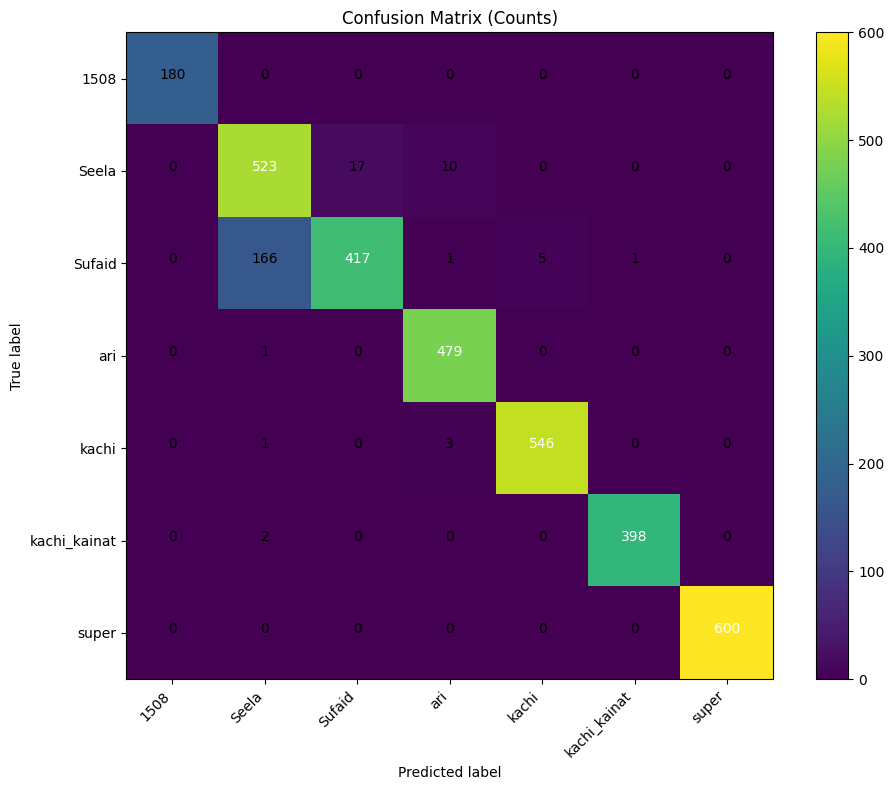

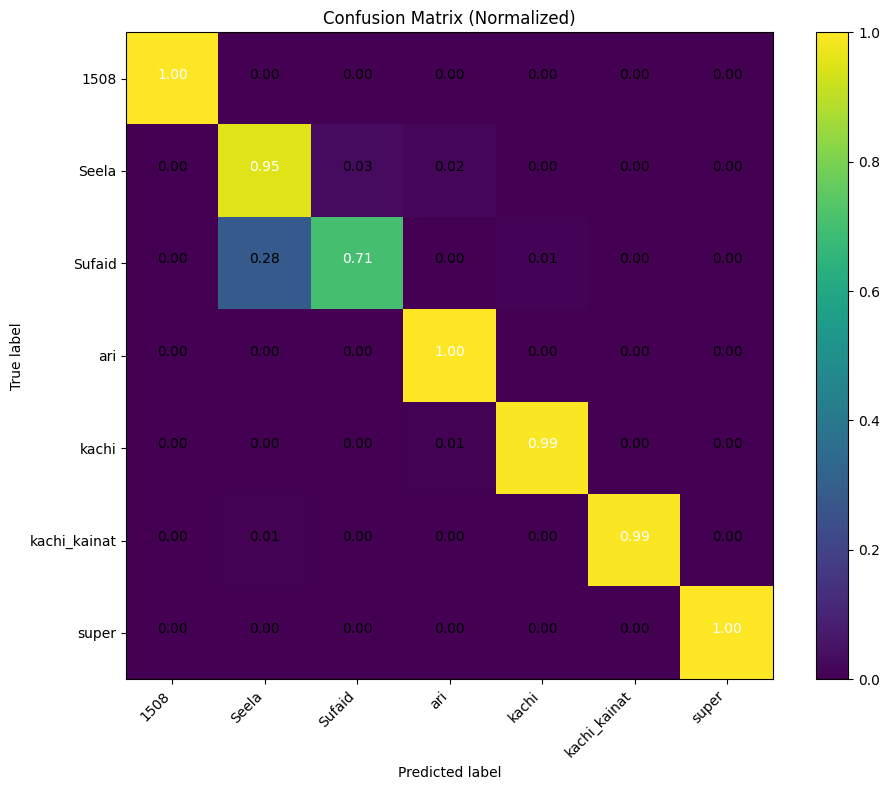

In [47]:
# =========================================================
# CELL 13 — Plot confusion matrix (counts + normalized)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_cm(cm, classes, normalize=False, title="Confusion matrix"):
    if normalize:
        cm_plot = cm.astype(float)
        cm_plot = cm_plot / cm_plot.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        cm_plot = cm
        fmt = "d"

    plt.figure(figsize=(10, 8))
    plt.imshow(cm_plot, interpolation="nearest")
    plt.title(title)
    plt.colorbar()

    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)

    thresh = cm_plot.max() / 2.0
    for i, j in itertools.product(range(cm_plot.shape[0]), range(cm_plot.shape[1])):
        plt.text(
            j, i,
            format(cm_plot[i, j], fmt),
            ha="center",
            color="white" if cm_plot[i, j] > thresh else "black"
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()


# Plot both versions
plot_cm(cm, class_names, normalize=False, title="Confusion Matrix (Counts)")
plot_cm(cm, class_names, normalize=True, title="Confusion Matrix (Normalized)")
plt.show()



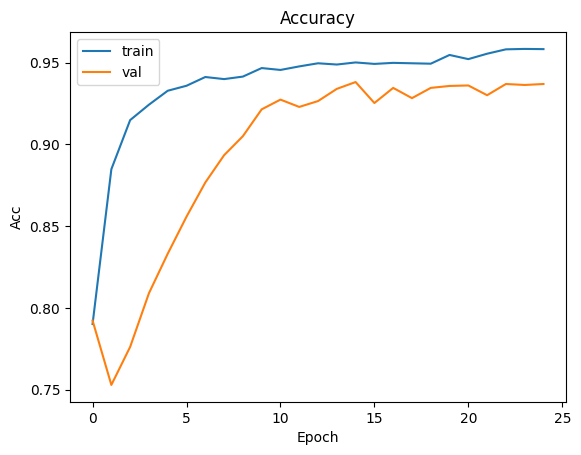

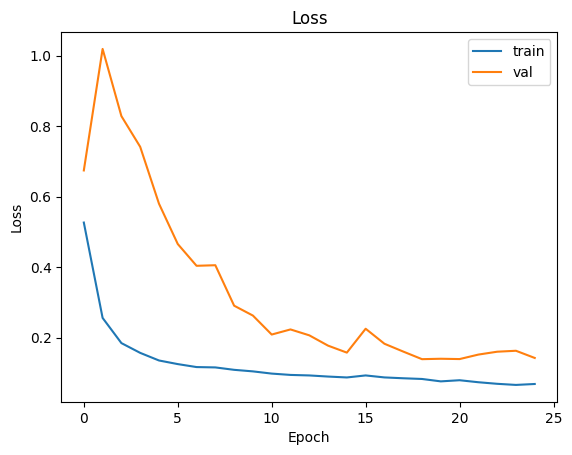

In [48]:
# =========================================================
# CELL 14 — Plot training curves (head + fine)
# =========================================================
def merge_histories(h1, h2):
    hist = {}
    keys = set(h1.history.keys()).union(h2.history.keys())
    for k in keys:
        hist[k] = h1.history.get(k, []) + h2.history.get(k, [])
    return hist

hist = merge_histories(history_head, history_fine)

plt.figure()
plt.plot(hist.get("accuracy", []))
plt.plot(hist.get("val_accuracy", []))
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(["train", "val"])
plt.show()

plt.figure()
plt.plot(hist.get("loss", []))
plt.plot(hist.get("val_loss", []))
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()


In [49]:
# =========================================================
# CELL 15 — Summary dict (copy to your model comparison sheet)
# =========================================================
total_params = best_model.count_params()
size_mb_est = (total_params * 4) / (1024**2)

summary = {
    "model": "MobileNetV2 (ImageNet) + fine-tune",
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "num_classes": NUM_CLASSES,
    "train_images": int(train_n),
    "val_images": int(val_n),
    "train_set_mb": float(round(train_bytes/(1024*1024), 2)),
    "val_set_mb": float(round(val_bytes/(1024*1024), 2)),
    "val_accuracy": float(val_acc),
    "val_loss": float(val_loss),
    "total_params": int(total_params),
    "estimated_model_size_mb_fp32": float(round(size_mb_est, 2)),
    "notes": "MobileNet baseline; train=Train.zip, val=Validation.zip; class weights + augmentation"
}
summary


{'model': 'MobileNetV2 (ImageNet) + fine-tune',
 'img_size': (224, 224),
 'batch_size': 64,
 'num_classes': 7,
 'train_images': 7852,
 'val_images': 3350,
 'train_set_mb': 49.81,
 'val_set_mb': 21.3,
 'val_accuracy': 0.9382089376449585,
 'val_loss': 0.15732310712337494,
 'total_params': 3006919,
 'estimated_model_size_mb_fp32': 11.47,
 'notes': 'MobileNet baseline; train=Train.zip, val=Validation.zip; class weights + augmentation'}

In [50]:
best_model.save("MobileNetV3_GR-ID_final.keras")
